# Adaptative threshold

In [2]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np
import seaborn as sns
from os import path
import tqdm

# >> for our model
from training_bert import BertNliLight
from custom_data_set import SnliDataset
from custom_data_set import test_dir
from torch.utils.data import DataLoader

# >> for the differents metrics
from attention_algorithms.raw_attention import RawAttention
from attention_algorithms.attention_metrics import default_plot_colormap
from attention_algorithms.attention_metrics import precision_recall_map
from attention_algorithms.attention_metrics import normalize_attention
from attention_algorithms.attention_visu import hightlight_txt, construct_html_table
from attention_algorithms.attention_visu import construct_html_page_visu
from sklearn.metrics import precision_score

# >> the cwd
cwd = os.getcwd().split(os.path.sep)
while cwd[-1] != "stage_4_gm":
    os.chdir("..")
    cwd = os.getcwd().split(os.path.sep)
print(">> the git rep : ", end="")
print(os.getcwd())

# >> where the plots will be saved
plots_folder = os.path.join(os.getcwd(), '.cache', 'plots')
graph_folder = path.join(plots_folder, "adaptative_tr")
if not path.exists(path.join(plots_folder, "adaptative_tr")):
    os.mkdir(path.join(plots_folder, "adaptative_tr"))

print(f">> the plots location : {graph_folder}")

>> the git rep : C:\Users\loicf\Documents\IRISA\stage_4_gm\stage_4_gm
>> the plots location : C:\Users\loicf\Documents\IRISA\stage_4_gm\stage_4_gm\.cache\plots\adaptative_tr


In [3]:
# load the model

ckp = path.join(".cache", "logs", "igrida_trained", "0", "best.ckpt")
model = BertNliLight.load_from_checkpoint(ckp)
model.eval()  # make sure to have the model in eval mod before using it

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertNliLight(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)

## Choose of the Threshold

In [4]:
# the data we annotated.
e_snli_data = pd.read_csv(os.path.join('.cache', 'raw_data', 'e_snli', 'cleaned_data', 'test.csv'), sep=",")\
    [["tok_sent", "hg_goal"]]
e_snli_data.head()

,tok_sent,hg_goal
0,"['[CLS]', 'this', 'church', 'choir', 'sings', ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"['[CLS]', 'this', 'church', 'choir', 'sings', ...","[0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ..."
2,"['[CLS]', 'this', 'church', 'choir', 'sings', ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
3,"['[CLS]', 'a', 'woman', 'with', 'a', 'green', ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"['[CLS]', 'a', 'woman', 'with', 'a', 'green', ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [5]:
buff = []
for i in range(e_snli_data.shape[0]):
    buff.append(sum(eval(e_snli_data.iloc[i]["hg_goal"]))/len(eval(e_snli_data.iloc[i]["hg_goal"])))
print(f">> On every sentence we have a mean of : {np.round(np.mean(buff)*100,3)} %")

>> On every sentence we have a mean of : 20.505 %


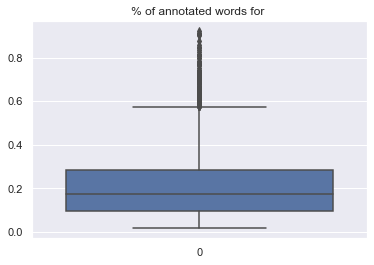

In [6]:
fig = sns.boxplot(data = buff)
t = plt.title("% of annotated words for ")

In [7]:
# this will be our quantile for the thresold
q_TR = 1 - np.mean(buff)
print(f">> we'll take the quantile of order {np.round(q_TR,3)}")

>> we'll take the quantile of order 0.795


## The adaptative threshold

In [8]:
# load the data
data_set = SnliDataset(dir=test_dir, nb_sentences=1000, msg=False)
data_loader = DataLoader(data_set, batch_size=1000, shuffle=False)

sentences, masks, train_labels = next(iter(data_loader))

print(f">> shape of the sentences : {sentences.shape}")
print(f">> shape of the masks : {masks.shape}")

pur_attention , map = precision_recall_map(sentences, masks, e_snli_data, q_TR, model)

>> shape of the sentences : torch.Size([1000, 150])
>> shape of the masks : torch.Size([1000, 150])
>> start the calculus for 1000 sentences


100%|██████████| 1000/1000 [04:42<00:00,  3.54it/s]


>> nb_errors : 21
>> len Y_test : 26600


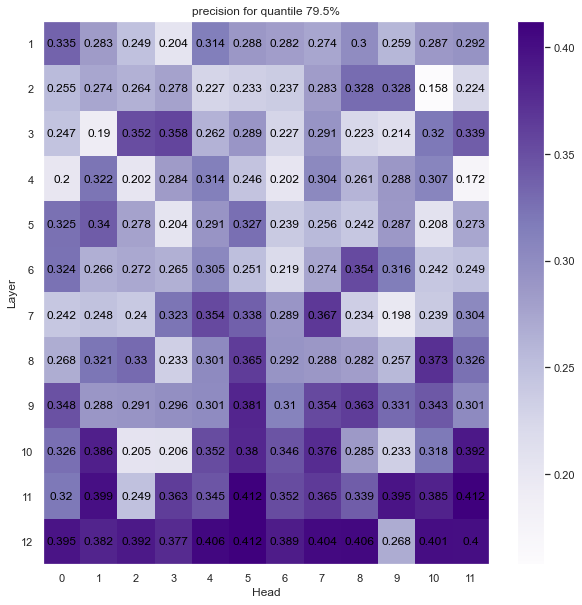

In [9]:
# plot the color map
fig = default_plot_colormap(map, xlabel="Head", ylabel="Layer", title=f"precision for quantile {np.round(q_TR,3)*100}%")
plt.savefig(os.path.join(graph_folder,"adaptative_TR_precision.png"))
plt.show()

## Layer combination
---
We will combine the heads over a Layer to provide a graphique similaire to the one of the AUC score over a Layer it will be much easier to use and to compare the result. We don't want to compare the result but to compare the evolution of the metrique over the layers.

In [1]:
# TODO : combine the different heads and provide the score to have similar images

## Combining the good heads (for the precision)

---

We will combine the score of the different heads, and we will combine these scores to provide the html page and to provide a visu of the attention map for a lot of sentences

In [26]:
# load the data

data_set_html = SnliDataset(dir=test_dir, nb_sentences=1000, msg=False)
data_loader_html = DataLoader(data_set, batch_size=1000, shuffle=False)

sentences, masks, train_labels = next(iter(data_loader_html))

annotations = []

for i in range(sentences.shape[0]):
    # >> this is where we can add some metrics to our html page
    buff_dict = {"ESNLI annotation" : None,
                 "precision annotation": None,
                 "precision score": 0,
                 "% sent 1 annot" : 0,
                 "% sent 2 annot" : 0}

    sent = sentences[i, :].clone().detach()[None, :]
    mk = masks[i, :].clone().detach()[None, :]
    raw_attention_inst = RawAttention(model=model,
                                      input_ids=sent,
                                      attention_mask=mk,
                                      test_mod=False
                                      )


    # the attention_score of the heads
    # we compute the sum of all the scores.
    AS_sent = np.zeros(len(raw_attention_inst.tokens))

    # we combine all the different annotations

    for l in range(12):
        for h in range(12):
            # apply the mask >> minimum of 40% precision
            if map[l,h] > 0.4 :
                # >> get the attention weights
                AS_sent += raw_attention_inst.attention_tensor[0,l,h,:,:].sum(dim=0).detach().numpy()

    # >> the normalization allow us to delete the special tokens
    AS_sent = normalize_attention(raw_attention_inst.tokens, torch.tensor(AS_sent)).detach().numpy()
    q = np.quantile(AS_sent, q_TR)
    AS_sent = np.array(AS_sent>=q, dtype=int)

    try :
        j = 0
        while eval(e_snli_data["tok_sent"][j]) != raw_attention_inst.tokens :
            j += 1


        vis = hightlight_txt(raw_attention_inst.tokens, AS_sent)
        buff_dict["precision annotation"] = vis

        vis = hightlight_txt(raw_attention_inst.tokens, torch.tensor(eval(e_snli_data["hg_goal"][j])))
        buff_dict["ESNLI annotation"] = vis

        vis = f'{np.round(precision_score(eval(e_snli_data["hg_goal"][j]), AS_sent), 3)*100}%'
        buff_dict["precision score"] = vis

        # >> which sentences is the most annotated
        sent_1 = True
        tot_annot = 0
        nb_sent_1 = 0
        nb_sent_2 = 0

        for t in range(len(raw_attention_inst.tokens)):
            # >> we go to the next sentence
            if raw_attention_inst.tokens[t] == "[SEP]":
                sent_1 = False

            if AS_sent[t]==1:
                tot_annot += 1
                if sent_1:
                    nb_sent_1 += 1
                else :
                    nb_sent_2 += 1

        vis = f'{np.round(nb_sent_1/tot_annot, 3)*100}%'
        buff_dict["% sent 1 annot"] = vis

        vis = f'{np.round(nb_sent_2/tot_annot, 3)*100}%'
        buff_dict["% sent 2 annot"] = vis


        annotations.append(buff_dict)
    except :
        pass

table = construct_html_table(list(buff_dict.keys()),
                             annotations)

error in the dataset
error in the dataset
error in the dataset
error in the dataset
error in the dataset
error in the dataset
error in the dataset
error in the dataset
error in the dataset
error in the dataset
error in the dataset
error in the dataset
error in the dataset
error in the dataset
error in the dataset
error in the dataset
error in the dataset
error in the dataset
error in the dataset
error in the dataset
error in the dataset


In [27]:
construct_html_page_visu(title="Plausibility for the precision metric",
                         table=table,
                         file_name="plausibility_precision_visu.html"
                         )